In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import src.plotter.utils as utils
from src.plotter.main import *
from copy import deepcopy
import math
from matplotlib.ticker import MaxNLocator

def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper


# Scenario A

In [2]:
BATCH_RESULT_PATH = "C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/SAMESERVICEGAUSIGMA2/"
OUTPUT_DIRECTORY_PATH = f"C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/plot/SAMESERVICEGAUSIGMA2/aggregated-{BATCH_RESULT_PATH.split('/')[-2]}-new/"

DEADLINES = [1000, 1000]
TIMESLOTS = 10000

def get_results_path(start_path=BATCH_RESULT_PATH):
    to_ret = []

    for file in os.listdir(start_path):
        if os.path.isdir(os.path.join(start_path, file)):
            to_ret.append(os.path.join(start_path, file, 'results.data'))

    return to_ret

results_path = get_results_path()

In [3]:
# getting policies_aggregated_stats 

policies_aggregated_stats = None

for r in results_path:
    imported_data = utils.import_serialized_data(r)
    if policies_aggregated_stats is None:
        policies_aggregated_stats = [{'name': imported_data[i]['name'], 'stats_per_slice': []} for i in range(len(imported_data))]

    for policy_index in range(len(imported_data)):
        policies_aggregated_stats[policy_index]['stats_per_slice'].append(
            {
             # the way we calculate the server_cap assumes the directory name like "something_NUMBEROFSERVERS"
             'server_cap': r.replace("\\", "/").split('/')[-2].split('_')[1],
             'slices': []
             }
        )

        slices = filter_stats_per_slice(split_stats_per_slice(imported_data[policy_index]['environment_data']))

        policies_aggregated_stats[policy_index]['stats_per_slice'][-1]['slices'].append(
            {
                'processed_jobs': sum(slices[0]['processed_jobs']),
                'incoming_jobs': sum(slices[0]['incoming_jobs']),
                'lost_jobs': sum(slices[0]['lost_jobs']),
                'toolate_jobs': sum(slices[0]['processed_jobs']) * sum(slices[0]['wait_time_in_the_system'][DEADLINES[0]:]),
                'cost': sum(slices[0]['cost']),
                'cost_component': np.array(slices[0]['cost_component']).sum(0).tolist(),
                'average_server_allocated': sum(slices[0]['active_servers'])/TIMESLOTS
             }
        )

        policies_aggregated_stats[policy_index]['stats_per_slice'][-1]['slices'].append(
            {
                'processed_jobs': sum(slices[1]['processed_jobs']),
                'incoming_jobs': sum(slices[1]['incoming_jobs']),
                'lost_jobs': sum(slices[1]['lost_jobs']),
                'toolate_jobs': sum(slices[1]['processed_jobs']) * sum(slices[1]['wait_time_in_the_system'][DEADLINES[1]:]),
                'cost': sum(slices[1]['cost']),
                'cost_component': np.array(slices[1]['cost_component']).sum(0).tolist(),
                'average_server_allocated': sum(slices[1]['active_servers'])/TIMESLOTS
            }
        )
        
dataframes = []

for policy in policies_aggregated_stats:
    servers_list = []
    processed_on_time_percent = [[], []]
    processed_too_late_percent = [[], []]
    lost_percent = [[], []]

    cost_job = [[], []]
    cost_server = [[], []]
    cost_lost = [[], []]
    cost_alloc = [[], []]
    cost_dealloc = [[], []]

    costs = [[], []]
    
    average_server_allocated = [[], []]
    

    for s in policy['stats_per_slice']:
        servers_list.append(s['server_cap'])

        lost_percent[0].append((s['slices'][0]['lost_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        lost_percent[1].append((s['slices'][1]['lost_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        processed_too_late_percent[0].append((s['slices'][0]['toolate_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        processed_too_late_percent[1].append((s['slices'][1]['toolate_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        s['slices'][0]['processed_jobs'] -= s['slices'][0]['toolate_jobs']
        s['slices'][1]['processed_jobs'] -= s['slices'][1]['toolate_jobs']

        processed_on_time_percent[0].append((s['slices'][0]['processed_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        processed_on_time_percent[1].append((s['slices'][1]['processed_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        cost_job[0].append(s['slices'][0]['cost_component'][0])
        cost_job[1].append(s['slices'][1]['cost_component'][0])

        cost_server[0].append(s['slices'][0]['cost_component'][1])
        cost_server[1].append(s['slices'][1]['cost_component'][1])

        cost_lost[0].append(s['slices'][0]['cost_component'][2])
        cost_lost[1].append(s['slices'][1]['cost_component'][2])

        cost_alloc[0].append(s['slices'][0]['cost_component'][3])
        cost_alloc[1].append(s['slices'][1]['cost_component'][3])

        cost_dealloc[0].append(s['slices'][0]['cost_component'][4])
        cost_dealloc[1].append(s['slices'][1]['cost_component'][4])

        costs[0].append(s['slices'][0]['cost'])
        costs[1].append(s['slices'][1]['cost'])
        
        average_server_allocated[0].append(s['slices'][0]['average_server_allocated'])
        average_server_allocated[1].append(s['slices'][1]['average_server_allocated'])
        

    dataframes.append(
        {
            'name': policy['name'],
            'slices': [
                pd.DataFrame({  # slice high priority
                    'server': servers_list,
                    'processed_on_time': processed_on_time_percent[0],
                    'processed_too_late': processed_too_late_percent[0],
                    'lost': lost_percent[0],
                    'cost_job': cost_job[0],
                    'cost_server': cost_server[0],
                    'cost_lost': cost_lost[0],
                    'cost_alloc': cost_alloc[0],
                    'cost_dealloc': cost_dealloc[0],
                    'cost_sum': costs[0],
                    'average_server_allocated': average_server_allocated[0]
                }),
                pd.DataFrame({  # slice low priority
                    'server': servers_list,
                    'processed_on_time': processed_on_time_percent[1],
                    'processed_too_late': processed_too_late_percent[1],
                    'lost': lost_percent[1],
                    'cost_job': cost_job[1],
                    'cost_server': cost_server[1],
                    'cost_lost': cost_lost[1],
                    'cost_alloc': cost_alloc[1],
                    'cost_dealloc': cost_dealloc[1],
                    'cost_sum': costs[1],
                    'average_server_allocated': average_server_allocated[1]
                })
            ]
        }
    )

    dataframes[-1]['slices'][0]['server'] = dataframes[-1]['slices'][0].astype(int)
    dataframes[-1]['slices'][1]['server'] = dataframes[-1]['slices'][1].astype(int)
    dataframes[-1]['slices'][0] = dataframes[-1]['slices'][0].sort_values(by=["server"]).set_index("server")
    dataframes[-1]['slices'][1] = dataframes[-1]['slices'][1].sort_values(by=["server"]).set_index("server")

In [4]:
slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_processed_on_time_slice_0 = \
    pd.DataFrame({
        'server': slice_0[0].index.to_list(),
        'SequentialMDP': slice_0[0]['processed_on_time'].to_list(),
        'SimplifiedMDP': slice_0[1]['processed_on_time'].to_list(),
        'ConservativeMDP': slice_0[3]['processed_on_time'].to_list(),
        'UniformStatic': slice_0[2]['processed_on_time'].to_list(),
        'PriorityStatic': slice_0[3]['processed_on_time'].to_list(),
                 })

df_processed_on_time_slice_0['server'] = df_processed_on_time_slice_0['server'].astype(int)
df_processed_on_time_slice_0 = df_processed_on_time_slice_0.sort_values(by=["server"]).set_index("server")


    
df_processed_on_time_slice_1 = \
    pd.DataFrame({
        'server': slice_1[0].index.to_list(),
        'SequentialMDP': slice_1[0]['processed_on_time'].to_list(),
        'SimplifiedMDP': slice_1[1]['processed_on_time'].to_list(),
        'ConservativeMDP': slice_1[1]['processed_on_time'].to_list(),
        'UniformStatic': slice_1[2]['processed_on_time'].to_list(),
        'PriorityStatic': slice_1[3]['processed_on_time'].to_list(),
    })

df_processed_on_time_slice_1['server'] = df_processed_on_time_slice_1['server'].astype(int)
df_processed_on_time_slice_1 = df_processed_on_time_slice_1.sort_values(by=["server"]).set_index("server")

In [5]:
slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_cost_slice_0 = \
    pd.DataFrame({
        'server': slice_0[0].index.to_list(),
        'SequentialMDP': (slice_0[0]['cost_sum']/TIMESLOTS).to_list(),
        'SimplifiedMDP': (slice_0[1]['cost_sum']/TIMESLOTS).to_list(),
        'ConservativeMDP': (slice_0[3]['cost_sum']/TIMESLOTS).to_list(),
        'UniformStatic': (slice_0[2]['cost_sum']/TIMESLOTS).to_list(),
        'PriorityStatic': (slice_0[3]['cost_sum']/TIMESLOTS).to_list(),
                 })

df_cost_slice_0['server'] = df_cost_slice_0['server'].astype(int)
df_cost_slice_0 = df_cost_slice_0.sort_values(by=["server"]).set_index("server")


    
df_cost_slice_1 = \
    pd.DataFrame({
        'server': slice_1[0].index.to_list(),
        'SequentialMDP': (slice_1[0]['cost_sum']/TIMESLOTS).to_list(),
        'SimplifiedMDP': (slice_1[1]['cost_sum']/TIMESLOTS).to_list(),
        'ConservativeMDP': (slice_1[1]['cost_sum']/TIMESLOTS).to_list(),
        'UniformStatic': (slice_1[2]['cost_sum']/TIMESLOTS).to_list(),
        'PriorityStatic': (slice_1[3]['cost_sum']/TIMESLOTS).to_list(),
    })

df_cost_slice_1['server'] = df_cost_slice_1['server'].astype(int)
df_cost_slice_1 = df_cost_slice_1.sort_values(by=["server"]).set_index("server")

In [6]:
slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_average_server_allocated_slice_0 = \
    pd.DataFrame({
        'server': slice_0[0].index.to_list(),
        'SequentialMDP': (slice_0[0]['average_server_allocated']).to_list(),
        'SimplifiedMDP': (slice_0[1]['average_server_allocated']).to_list(),
        'ConservativeMDP': (slice_0[3]['average_server_allocated']).to_list(),
        'UniformStatic': (slice_0[2]['average_server_allocated']).to_list(),
        'PriorityStatic': (slice_0[3]['average_server_allocated']).to_list(),
                 })

df_average_server_allocated_slice_0['server'] = df_average_server_allocated_slice_0['server'].astype(int)
df_average_server_allocated_slice_0 = df_average_server_allocated_slice_0.sort_values(by=["server"]).set_index("server")


    
df_average_server_allocated_slice_1 = \
    pd.DataFrame({
        'server': slice_1[0].index.to_list(),
        'SequentialMDP': (slice_1[0]['average_server_allocated']).to_list(),
        'SimplifiedMDP': (slice_1[1]['average_server_allocated']).to_list(),
        'ConservativeMDP': (slice_1[1]['average_server_allocated']).to_list(),
        'UniformStatic': (slice_1[2]['average_server_allocated']).to_list(),
        'PriorityStatic': (slice_1[3]['average_server_allocated']).to_list(),
    })

df_average_server_allocated_slice_1['server'] = df_average_server_allocated_slice_1['server'].astype(int)
df_average_server_allocated_slice_1 = df_average_server_allocated_slice_1.sort_values(by=["server"]).set_index("server")

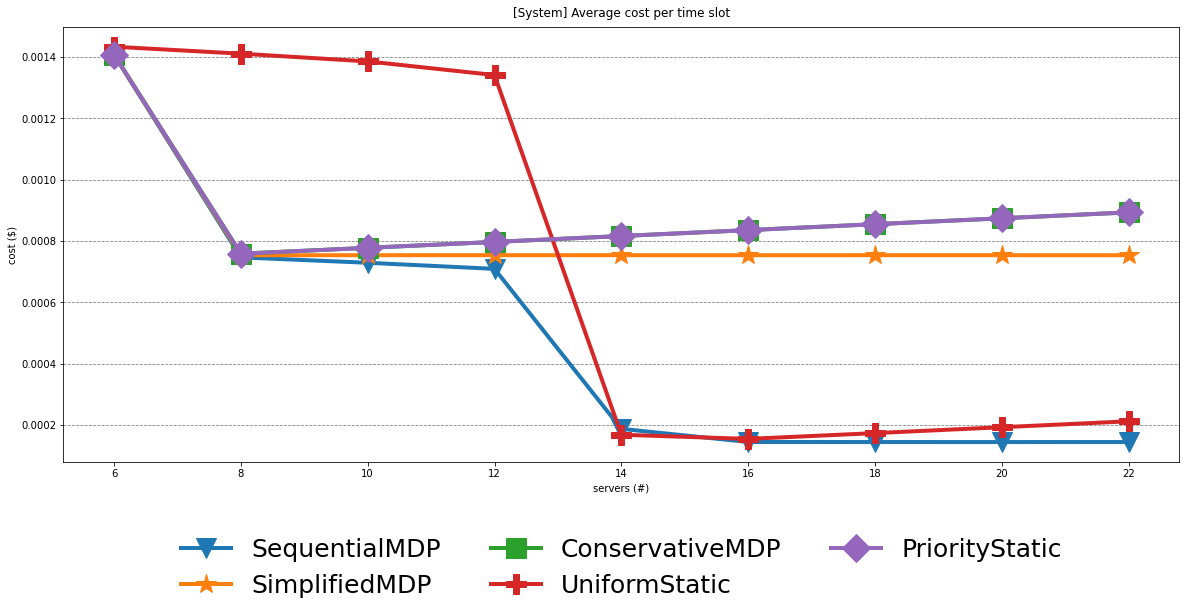

In [7]:
markers = ['v', '*', 's', 'P', 'D']

ax = (df_cost_slice_0 + df_cost_slice_1).plot(
        kind='line',
        figsize=(20, 8),
        linewidth=4,

    )

for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
    line.set_markersize(20)

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[System] Average cost per time slot", pad=10)
ax.set_ylabel('cost ($)')
ax.set_xlabel('servers (#)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}cost_allslice_allpolicy_JUPYTER", bbox_inches='tight')

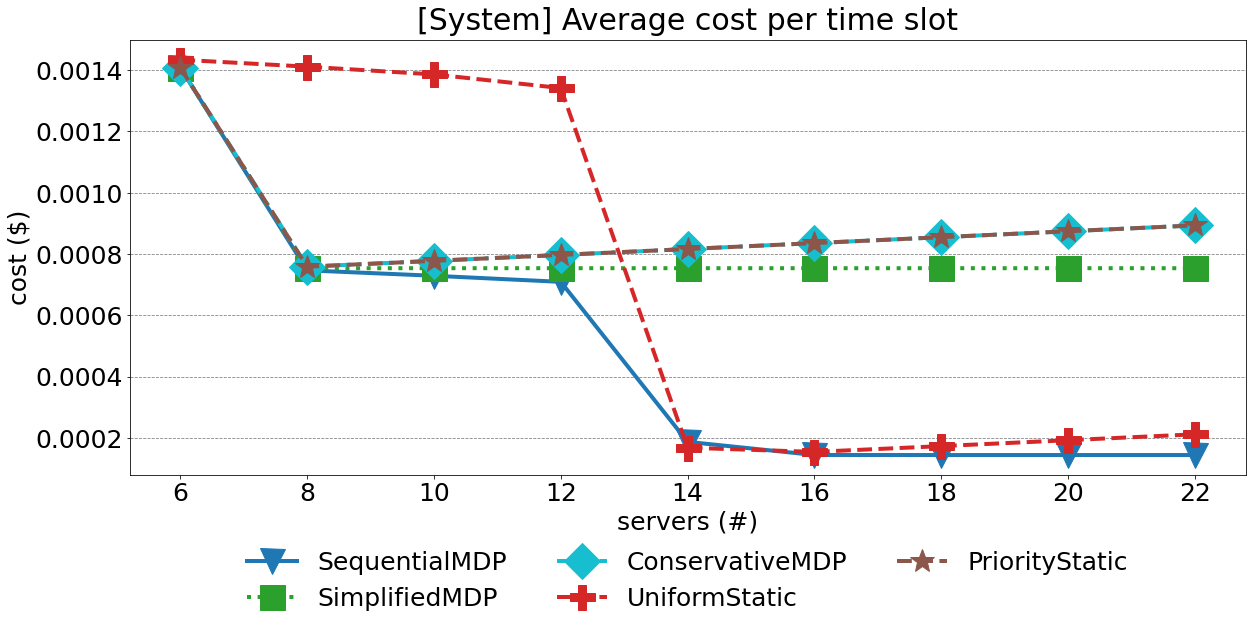

In [8]:
line_styles = ['-',':','-.','--', '--']
markers = ['v', 's', 'D', 'P', '*']

ax = (df_cost_slice_0 + df_cost_slice_1).plot(
        kind='line',
        figsize=(20, 8),
        linewidth=4,
        style=line_styles,
        color=['tab:blue', 'tab:green', 'tab:cyan', 'tab:red', 'tab:brown']
    )

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[System] Average cost per time slot", pad=10)
ax.set_ylabel('cost ($)')
ax.set_xlabel('servers (#)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
    line.set_markersize(25)

    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}cost_allslice_allpolicy_linestyle_JUPYTER", bbox_inches='tight')

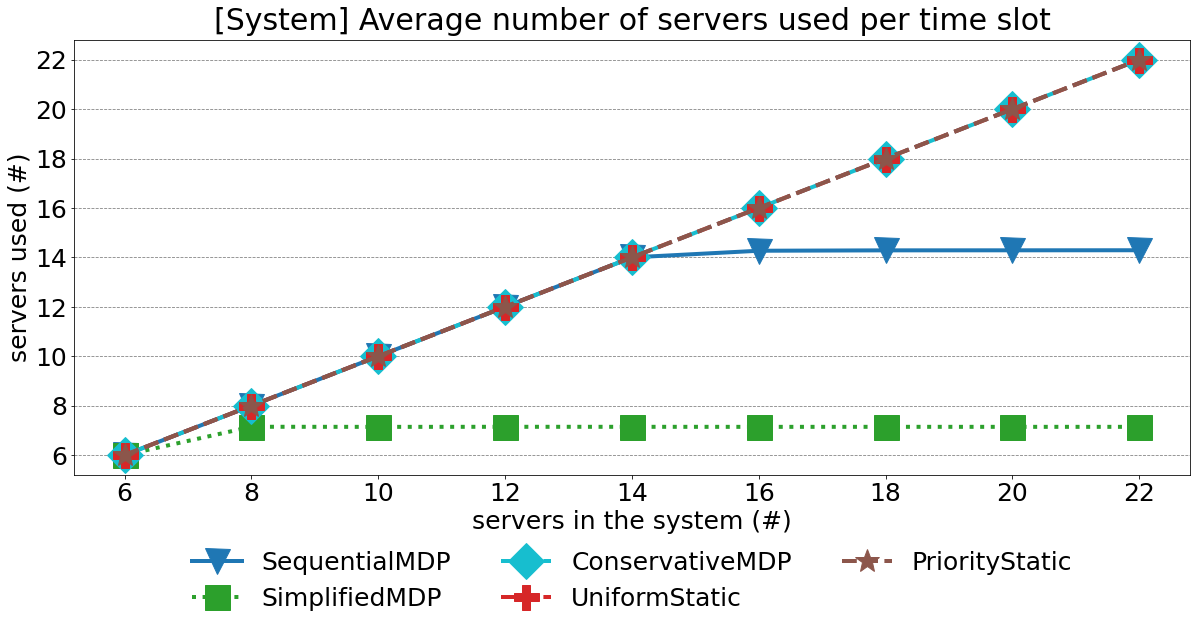

In [9]:
line_styles = ['-',':','-.','--', '--']
markers = ['v', 's', 'D', 'P', '*']

ax = (df_average_server_allocated_slice_0 + df_average_server_allocated_slice_1).plot(
        kind='line',
        figsize=(20, 8),
        linewidth=4,
        style=line_styles,
        color=['tab:blue', 'tab:green', 'tab:cyan', 'tab:red', 'tab:brown']
    )

ax.yaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_title(f"[System] Average number of servers used per time slot", pad=10)
ax.set_ylabel('servers used (#)')
ax.set_xlabel('servers in the system (#)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
    line.set_markersize(25)

    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}serverutilization_allslice_allpolicy_linestyle_JUPYTER", bbox_inches='tight')

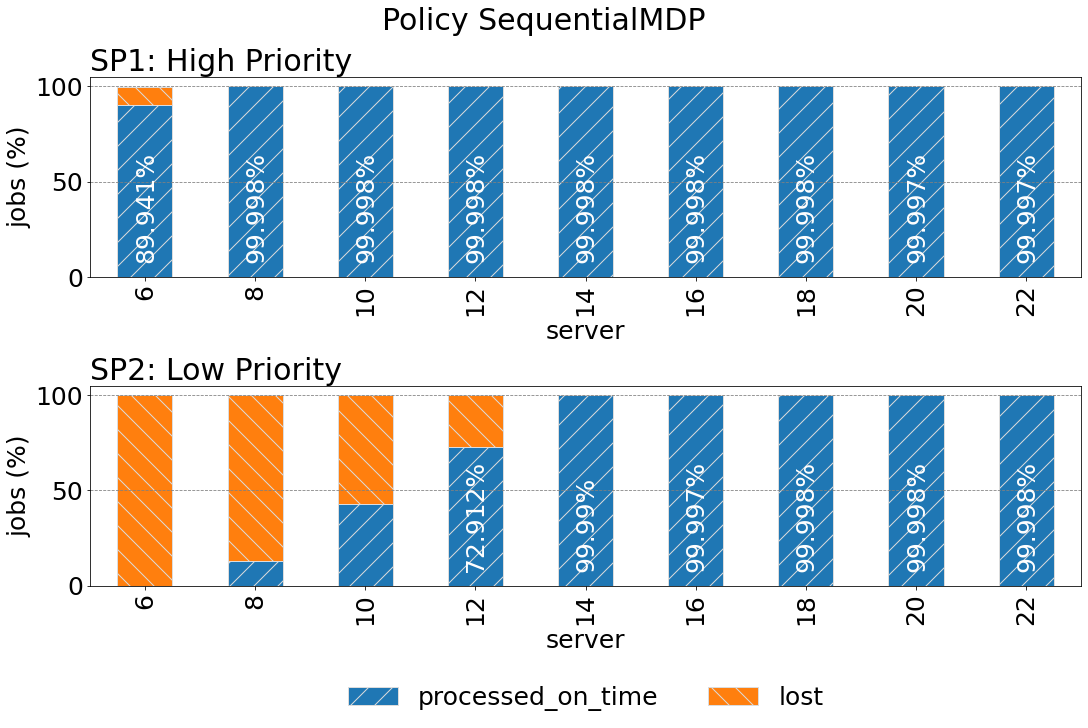

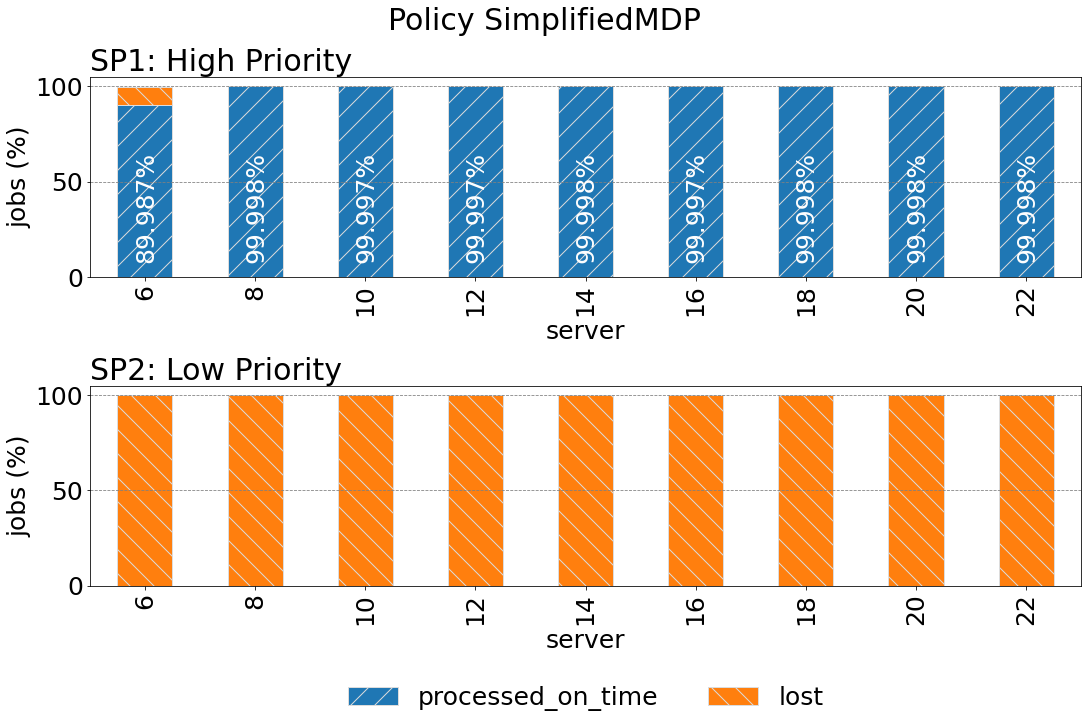

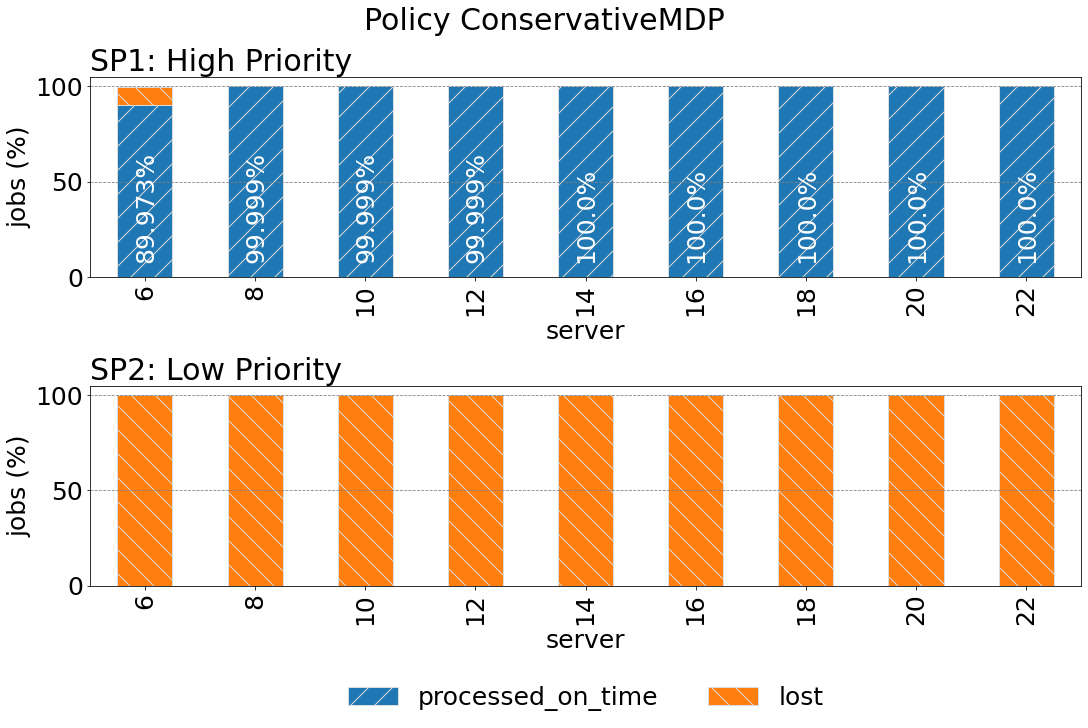

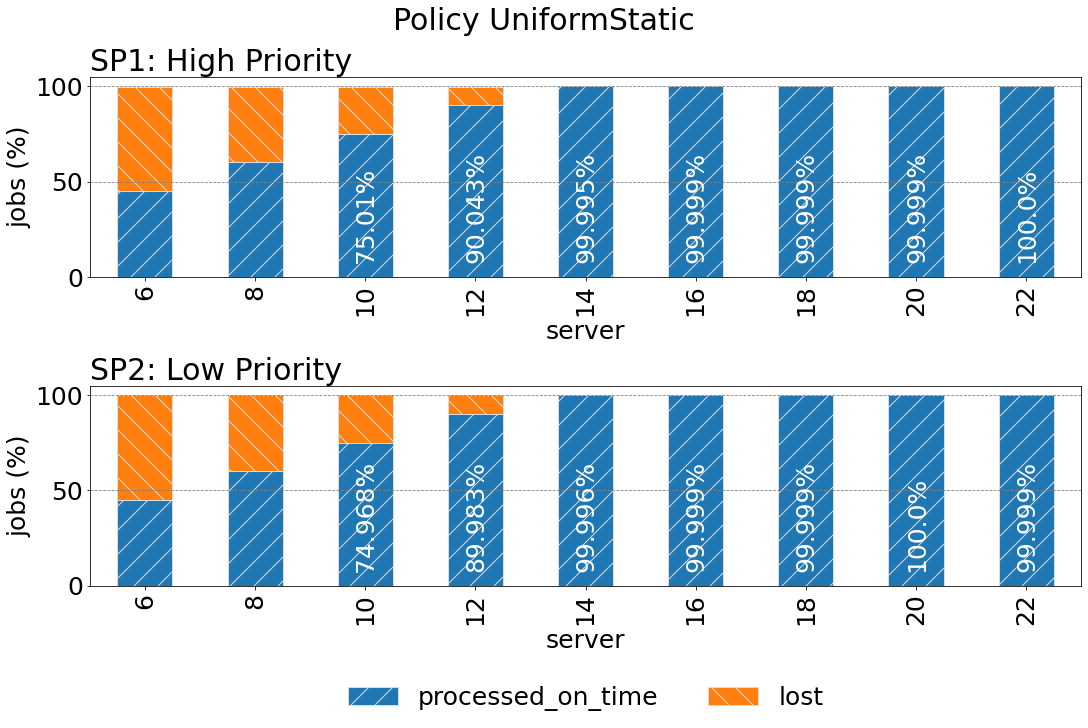

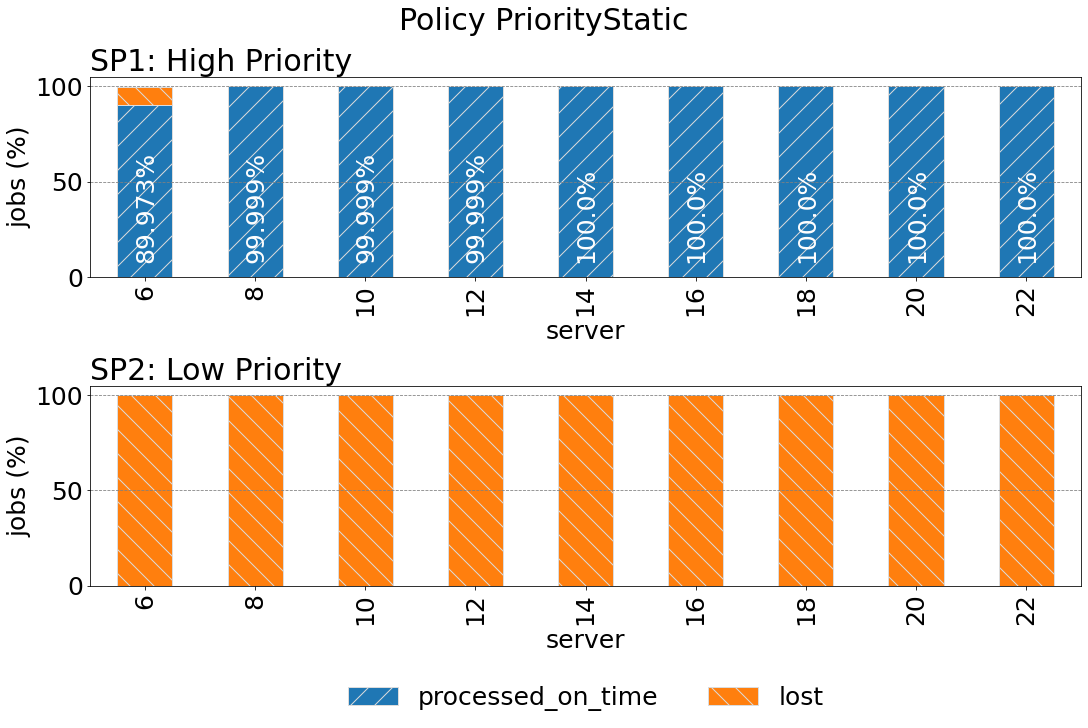

In [10]:
# this version should be used for "sameservice", two different services should have a separate code
patterns =('/','\\', '-')

new_df = deepcopy(dataframes)

#creating syntetic conservative mdp policy
a = deepcopy(dataframes[0])
a['name'] = 'ConservativeMDP'
a['slices'][0] = deepcopy(dataframes[3]['slices'][0])
a['slices'][1] = deepcopy(dataframes[1]['slices'][1])

new_df.insert(2, a)

policy_names = ["SequentialMDP", "SimplifiedMDP", "ConservativeMDP", "UniformStatic", "PriorityStatic"]
plt.rcParams.update({'font.size': 25})

for i in range(len(policy_names)):
    # df0 = new_df[0]['slices'][0][['processed_on_time', 'processed_too_late', 'lost']]
    # df1 = new_df[0]['slices'][1][['processed_on_time', 'processed_too_late', 'lost']]
    df0 = new_df[i]['slices'][0][['processed_on_time', 'lost']]
    df1 = new_df[i]['slices'][1][['processed_on_time', 'lost']]

    fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(15, 10))

    axs[0].set_title("SP1: High Priority", loc="left")
    axs[1].set_title("SP2: Low Priority", loc="left")
    axs[0].set_ylabel("jobs (%)")
    axs[1].set_ylabel("jobs (%)")

    axs[1].set_xlabel('servers (#)')

    fig.suptitle(f"Policy {policy_names[i]}")
    df0.plot(
        kind='bar',
        stacked=True,
        width=0.5,
        ax=axs[0],
        legend=False
    )

    axs[0].grid(axis='y', which='both', color='grey', linestyle='dashed')
    df1.plot(
        kind='bar',
        stacked=True,
        width=0.5,
        ax=axs[1],
        legend=False
    )

    axs[1].grid(axis='y', which='both', color='grey', linestyle='dashed')

    bars = axs[0].patches
    hatches = [p for p in patterns for i in range(len(df0))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        bar.set_edgecolor('gainsboro')
        
    bars = axs[1].patches
    hatches = [p for p in patterns for i in range(len(df0))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        bar.set_edgecolor('gainsboro')

    number_of_servers_max = len(df_processed_on_time_slice_0[policy_names[i]].tolist())
            
    for count, value in enumerate(axs[0].patches):
        if value.get_height() > 70 and count < number_of_servers_max:
            axs[0].text(value.get_x() + 0.15, 10,
                    str(truncate((value.get_height()), 3)) + '%', fontsize=25, color='white', rotation=90)
     
    for count, value in enumerate(axs[1].patches):
        if value.get_height() > 70 and count < number_of_servers_max:
            axs[1].text(value.get_x() + 0.15, 10,
                    str(truncate((value.get_height()), 3)) + '%', fontsize=25, color='white', rotation=90)



    
    axs[1].legend(bbox_to_anchor=(0.5, -0.45), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)
    plt.savefig(f"{OUTPUT_DIRECTORY_PATH}overview_policy-{policy_names[i]}_JUPYTER", bbox_inches='tight')

# -----------------------------------------------------------------------------------------------------

# Scenario B

In [11]:
BATCH_RESULT_PATH = "C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/GAUSIGMA2/"
OUTPUT_DIRECTORY_PATH = f"C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/plot/GAUSIGMA2/aggregated-{BATCH_RESULT_PATH.split('/')[-2]}-new/"

DEADLINES = [1, 5]
TIMESLOTS = 10000

def get_results_path(start_path=BATCH_RESULT_PATH):
    to_ret = []

    for file in os.listdir(start_path):
        if os.path.isdir(os.path.join(start_path, file)):
            to_ret.append(os.path.join(start_path, file, 'results.data'))

    return to_ret

results_path = get_results_path()

In [12]:
# getting policies_aggregated_stats 

policies_aggregated_stats = None

for r in results_path:
    imported_data = utils.import_serialized_data(r)
    if policies_aggregated_stats is None:
        policies_aggregated_stats = [{'name': imported_data[i]['name'], 'stats_per_slice': []} for i in range(len(imported_data))]

    for policy_index in range(len(imported_data)):
        policies_aggregated_stats[policy_index]['stats_per_slice'].append(
            {
             # the way we calculate the server_cap assumes the directory name like "something_NUMBEROFSERVERS"
             'server_cap': r.replace("\\", "/").split('/')[-2].split('_')[1],
             'slices': []
             }
        )

        slices = filter_stats_per_slice(split_stats_per_slice(imported_data[policy_index]['environment_data']))
        
        policies_aggregated_stats[policy_index]['stats_per_slice'][-1]['slices'].append(
            {
                'processed_jobs': sum(slices[0]['processed_jobs']),
                'incoming_jobs': sum(slices[0]['incoming_jobs']),
                'lost_jobs': sum(slices[0]['lost_jobs']),
                'toolate_jobs': sum(slices[0]['processed_jobs']) * sum(slices[0]['wait_time_in_the_system'][DEADLINES[0]:]),
                'cost': sum(slices[0]['cost']),
                'cost_component': np.array(slices[0]['cost_component']).sum(0).tolist(),
                'average_server_allocated': sum(slices[0]['active_servers'])/TIMESLOTS,
                'average_jobs_in_queue': sum(slices[0]['jobs_in_queue'])/TIMESLOTS
             }
        )

        policies_aggregated_stats[policy_index]['stats_per_slice'][-1]['slices'].append(
            {
                'processed_jobs': sum(slices[1]['processed_jobs']),
                'incoming_jobs': sum(slices[1]['incoming_jobs']),
                'lost_jobs': sum(slices[1]['lost_jobs']),
                'toolate_jobs': sum(slices[1]['processed_jobs']) * sum(slices[1]['wait_time_in_the_system'][DEADLINES[1]:]),
                'cost': sum(slices[1]['cost']),
                'cost_component': np.array(slices[1]['cost_component']).sum(0).tolist(),
                'average_server_allocated': sum(slices[1]['active_servers'])/TIMESLOTS,
                'average_jobs_in_queue': sum(slices[1]['jobs_in_queue'])/TIMESLOTS
            }
        )
        
dataframes = []

for policy in policies_aggregated_stats:
    servers_list = []
    processed_on_time_percent = [[], []]
    processed_too_late_percent = [[], []]
    lost_percent = [[], []]

    cost_job = [[], []]
    cost_server = [[], []]
    cost_lost = [[], []]
    cost_alloc = [[], []]
    cost_dealloc = [[], []]

    costs = [[], []]
    
    average_server_allocated = [[], []]
    average_jobs_in_queue = [[], []]
    

    for s in policy['stats_per_slice']:
        servers_list.append(s['server_cap'])

        lost_percent[0].append((s['slices'][0]['lost_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        lost_percent[1].append((s['slices'][1]['lost_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        processed_too_late_percent[0].append((s['slices'][0]['toolate_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        processed_too_late_percent[1].append((s['slices'][1]['toolate_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        s['slices'][0]['processed_jobs'] -= s['slices'][0]['toolate_jobs']
        s['slices'][1]['processed_jobs'] -= s['slices'][1]['toolate_jobs']

        processed_on_time_percent[0].append((s['slices'][0]['processed_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        processed_on_time_percent[1].append((s['slices'][1]['processed_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        cost_job[0].append(s['slices'][0]['cost_component'][0])
        cost_job[1].append(s['slices'][1]['cost_component'][0])

        cost_server[0].append(s['slices'][0]['cost_component'][1])
        cost_server[1].append(s['slices'][1]['cost_component'][1])

        cost_lost[0].append(s['slices'][0]['cost_component'][2])
        cost_lost[1].append(s['slices'][1]['cost_component'][2])

        cost_alloc[0].append(s['slices'][0]['cost_component'][3])
        cost_alloc[1].append(s['slices'][1]['cost_component'][3])

        cost_dealloc[0].append(s['slices'][0]['cost_component'][4])
        cost_dealloc[1].append(s['slices'][1]['cost_component'][4])

        costs[0].append(s['slices'][0]['cost'])
        costs[1].append(s['slices'][1]['cost'])
        
        average_server_allocated[0].append(s['slices'][0]['average_server_allocated'])
        average_server_allocated[1].append(s['slices'][1]['average_server_allocated'])
        
        average_jobs_in_queue[0].append(s['slices'][0]['average_jobs_in_queue'])
        average_jobs_in_queue[1].append(s['slices'][1]['average_jobs_in_queue'])
        

    dataframes.append(
        {
            'name': policy['name'],
            'slices': [
                pd.DataFrame({  # slice high priority
                    'server': servers_list,
                    'processed_on_time': processed_on_time_percent[0],
                    'processed_too_late': processed_too_late_percent[0],
                    'lost': lost_percent[0],
                    'cost_job': cost_job[0],
                    'cost_server': cost_server[0],
                    'cost_lost': cost_lost[0],
                    'cost_alloc': cost_alloc[0],
                    'cost_dealloc': cost_dealloc[0],
                    'cost_sum': costs[0],
                    'average_server_allocated': average_server_allocated[0],
                    'average_jobs_in_queue': average_jobs_in_queue[0]
                }),
                pd.DataFrame({  # slice low priority
                    'server': servers_list,
                    'processed_on_time': processed_on_time_percent[1],
                    'processed_too_late': processed_too_late_percent[1],
                    'lost': lost_percent[1],
                    'cost_job': cost_job[1],
                    'cost_server': cost_server[1],
                    'cost_lost': cost_lost[1],
                    'cost_alloc': cost_alloc[1],
                    'cost_dealloc': cost_dealloc[1],
                    'cost_sum': costs[1],
                    'average_server_allocated': average_server_allocated[1],
                    'average_jobs_in_queue': average_jobs_in_queue[1]
                })
            ]
        }
    )

    dataframes[-1]['slices'][0]['server'] = dataframes[-1]['slices'][0].astype(int)
    dataframes[-1]['slices'][1]['server'] = dataframes[-1]['slices'][1].astype(int)
    dataframes[-1]['slices'][0] = dataframes[-1]['slices'][0].sort_values(by=["server"]).set_index("server")
    dataframes[-1]['slices'][1] = dataframes[-1]['slices'][1].sort_values(by=["server"]).set_index("server")

In [13]:
slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_processed_on_time_slice_0 = \
    pd.DataFrame({
        'server': slice_0[0].index.to_list(),
        'SequentialMDP': slice_0[0]['processed_on_time'].to_list(),
        'SimplifiedMDP': slice_0[1]['processed_on_time'].to_list(),
        'ConservativeMDP': slice_0[3]['processed_on_time'].to_list(),
        'UniformStatic': slice_0[2]['processed_on_time'].to_list(),
        'PriorityStatic': slice_0[3]['processed_on_time'].to_list(),
                 })

df_processed_on_time_slice_0['server'] = df_processed_on_time_slice_0['server'].astype(int)
df_processed_on_time_slice_0 = df_processed_on_time_slice_0.sort_values(by=["server"]).set_index("server")


    
df_processed_on_time_slice_1 = \
    pd.DataFrame({
        'server': slice_1[0].index.to_list(),
        'SequentialMDP': slice_1[0]['processed_on_time'].to_list(),
        'SimplifiedMDP': slice_1[1]['processed_on_time'].to_list(),
        'ConservativeMDP': slice_1[1]['processed_on_time'].to_list(),
        'UniformStatic': slice_1[2]['processed_on_time'].to_list(),
        'PriorityStatic': slice_1[3]['processed_on_time'].to_list(),
    })

df_processed_on_time_slice_1['server'] = df_processed_on_time_slice_1['server'].astype(int)
df_processed_on_time_slice_1 = df_processed_on_time_slice_1.sort_values(by=["server"]).set_index("server")

In [14]:
slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_cost_slice_0 = \
    pd.DataFrame({
        'server': slice_0[0].index.to_list(),
        'SequentialMDP': (slice_0[0]['cost_sum']/TIMESLOTS).to_list(),
        'SimplifiedMDP': (slice_0[1]['cost_sum']/TIMESLOTS).to_list(),
        'ConservativeMDP': (slice_0[3]['cost_sum']/TIMESLOTS).to_list(),
        'UniformStatic': (slice_0[2]['cost_sum']/TIMESLOTS).to_list(),
        'PriorityStatic': (slice_0[3]['cost_sum']/TIMESLOTS).to_list(),
                 })

df_cost_slice_0['server'] = df_cost_slice_0['server'].astype(int)
df_cost_slice_0 = df_cost_slice_0.sort_values(by=["server"]).set_index("server")


    
df_cost_slice_1 = \
    pd.DataFrame({
        'server': slice_1[0].index.to_list(),
        'SequentialMDP': (slice_1[0]['cost_sum']/TIMESLOTS).to_list(),
        'SimplifiedMDP': (slice_1[1]['cost_sum']/TIMESLOTS).to_list(),
        'ConservativeMDP': (slice_1[1]['cost_sum']/TIMESLOTS).to_list(),
        'UniformStatic': (slice_1[2]['cost_sum']/TIMESLOTS).to_list(),
        'PriorityStatic': (slice_1[3]['cost_sum']/TIMESLOTS).to_list(),
    })

df_cost_slice_1['server'] = df_cost_slice_1['server'].astype(int)
df_cost_slice_1 = df_cost_slice_1.sort_values(by=["server"]).set_index("server")

In [15]:
slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_average_server_allocated_slice_0 = \
    pd.DataFrame({
        'server': slice_0[0].index.to_list(),
        'SequentialMDP': (slice_0[0]['average_server_allocated']).to_list(),
        'SimplifiedMDP': (slice_0[1]['average_server_allocated']).to_list(),
        'ConservativeMDP': (slice_0[3]['average_server_allocated']).to_list(),
        'UniformStatic': (slice_0[2]['average_server_allocated']).to_list(),
        'PriorityStatic': (slice_0[3]['average_server_allocated']).to_list(),
                 })

df_average_server_allocated_slice_0['server'] = df_average_server_allocated_slice_0['server'].astype(int)
df_average_server_allocated_slice_0 = df_average_server_allocated_slice_0.sort_values(by=["server"]).set_index("server")


    
df_average_server_allocated_slice_1 = \
    pd.DataFrame({
        'server': slice_1[0].index.to_list(),
        'SequentialMDP': (slice_1[0]['average_server_allocated']).to_list(),
        'SimplifiedMDP': (slice_1[1]['average_server_allocated']).to_list(),
        'ConservativeMDP': (slice_1[1]['average_server_allocated']).to_list(),
        'UniformStatic': (slice_1[2]['average_server_allocated']).to_list(),
        'PriorityStatic': (slice_1[3]['average_server_allocated']).to_list(),
    })

df_average_server_allocated_slice_1['server'] = df_average_server_allocated_slice_1['server'].astype(int)
df_average_server_allocated_slice_1 = df_average_server_allocated_slice_1.sort_values(by=["server"]).set_index("server")

In [16]:
slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_average_jobs_in_queue_slice_0 = \
    pd.DataFrame({
        'server': slice_0[0].index.to_list(),
        'SequentialMDP': (slice_0[0]['average_jobs_in_queue']).to_list(),
        'SimplifiedMDP': (slice_0[1]['average_jobs_in_queue']).to_list(),
        'ConservativeMDP': (slice_0[3]['average_jobs_in_queue']).to_list(),
        'UniformStatic': (slice_0[2]['average_jobs_in_queue']).to_list(),
        'PriorityStatic': (slice_0[3]['average_jobs_in_queue']).to_list(),
                 })

df_average_jobs_in_queue_slice_0['server'] = df_average_jobs_in_queue_slice_0['server'].astype(int)
df_average_jobs_in_queue_slice_0 = df_average_jobs_in_queue_slice_0.sort_values(by=["server"]).set_index("server")


    
df_average_jobs_in_queue_slice_1 = \
    pd.DataFrame({
        'server': slice_1[0].index.to_list(),
        'SequentialMDP': (slice_1[0]['average_jobs_in_queue']).to_list(),
        'SimplifiedMDP': (slice_1[1]['average_jobs_in_queue']).to_list(),
        'ConservativeMDP': (slice_1[1]['average_jobs_in_queue']).to_list(),
        'UniformStatic': (slice_1[2]['average_jobs_in_queue']).to_list(),
        'PriorityStatic': (slice_1[3]['average_jobs_in_queue']).to_list(),
    })

df_average_jobs_in_queue_slice_1['server'] = df_average_jobs_in_queue_slice_1['server'].astype(int)
df_average_jobs_in_queue_slice_1 = df_average_jobs_in_queue_slice_1.sort_values(by=["server"]).set_index("server")

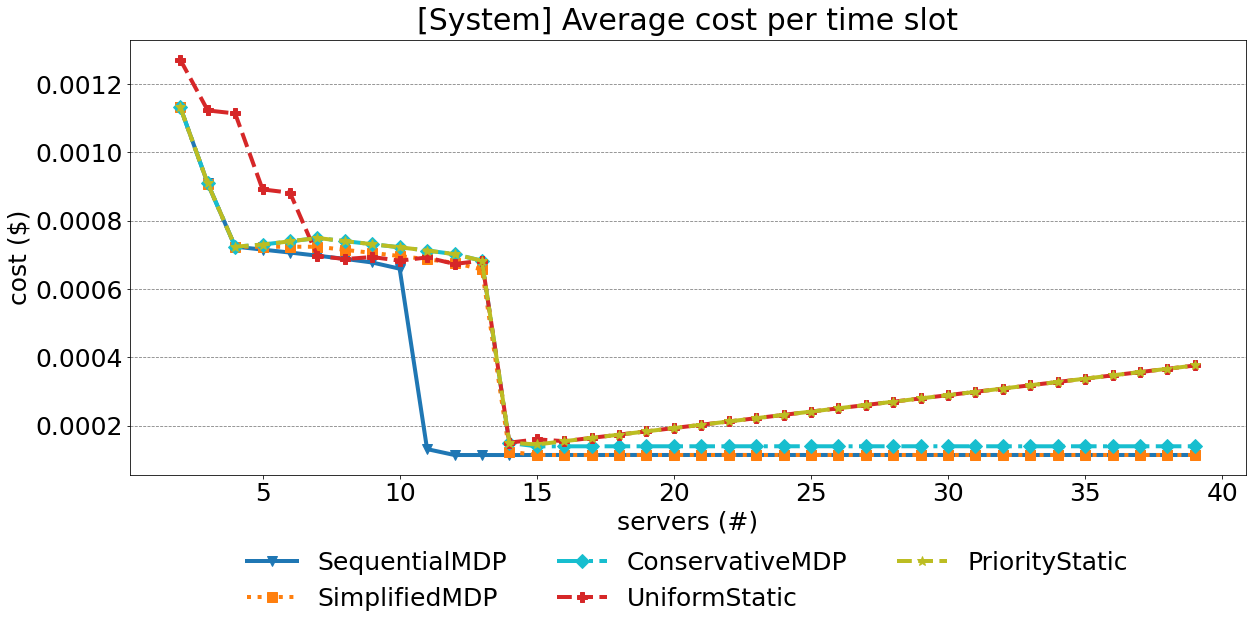

In [17]:
line_styles = ['-',':','-.','--', '--']
markers = ['v', 's', 'D', 'P', '*']

ax = (df_cost_slice_0 + df_cost_slice_1).plot(
        kind='line',
        figsize=(20, 8),
        linewidth=4,
        style=line_styles,
        color=['tab:blue', 'tab:orange', 'tab:cyan', 'tab:red', 'tab:olive']
    )

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[System] Average cost per time slot", pad=10)
ax.set_ylabel('cost ($)')
ax.set_xlabel('servers (#)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
    line.set_markersize(10)

    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}cost_allslice_allpolicy_linestyle_JUPYTER", bbox_inches='tight')

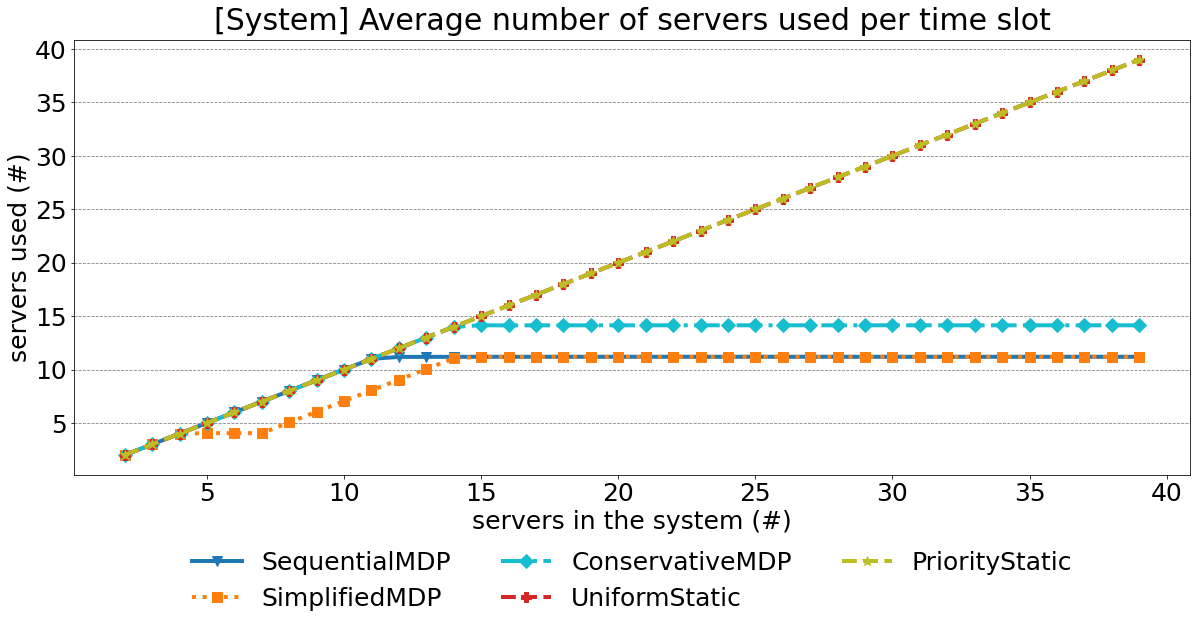

In [18]:
line_styles = ['-',':','-.','--', '--']
markers = ['v', 's', 'D', 'P', '*']

ax = (df_average_server_allocated_slice_0 + df_average_server_allocated_slice_1).plot(
        kind='line',
        figsize=(20, 8),
        linewidth=4,
        style=line_styles,
        color=['tab:blue', 'tab:orange', 'tab:cyan', 'tab:red', 'tab:olive']
    )

ax.yaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_title(f"[System] Average number of servers used per time slot", pad=10)
ax.set_ylabel('servers used (#)')
ax.set_xlabel('servers in the system (#)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
    line.set_markersize(10)

    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}serverutilization_allslice_allpolicy_linestyle_JUPYTER", bbox_inches='tight')

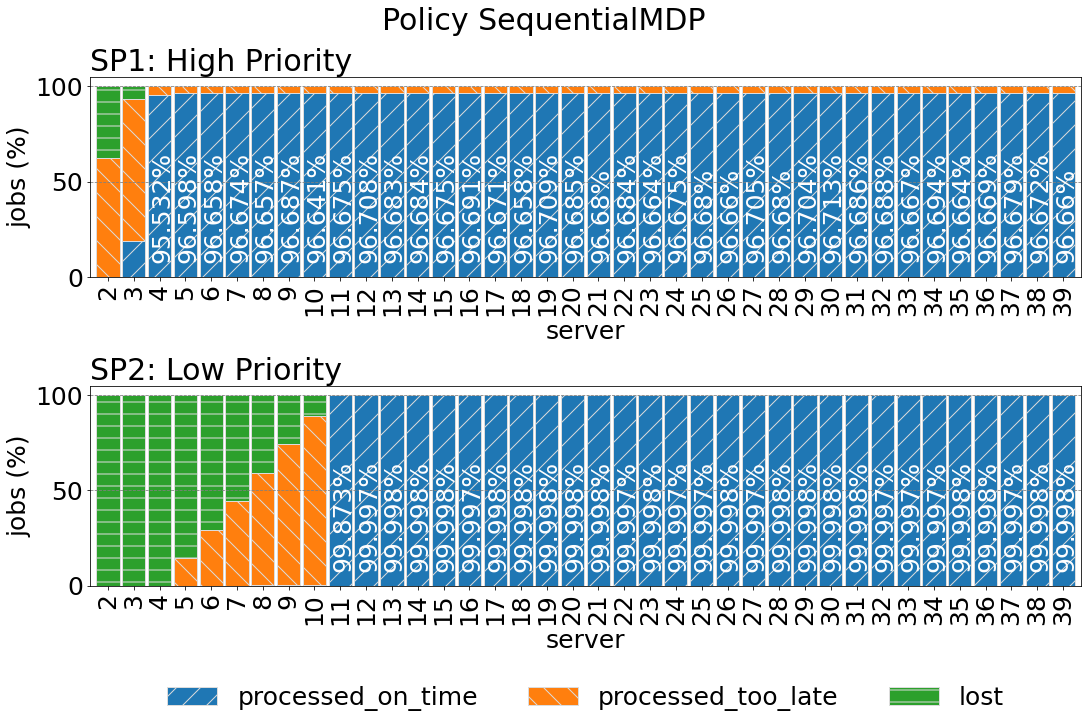

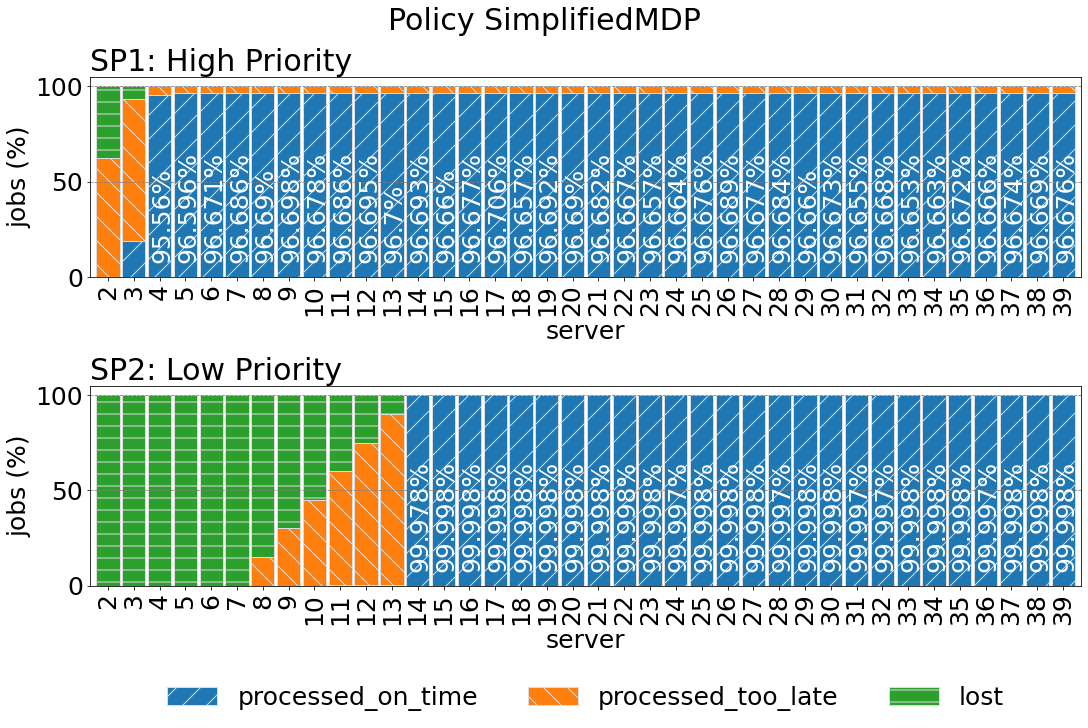

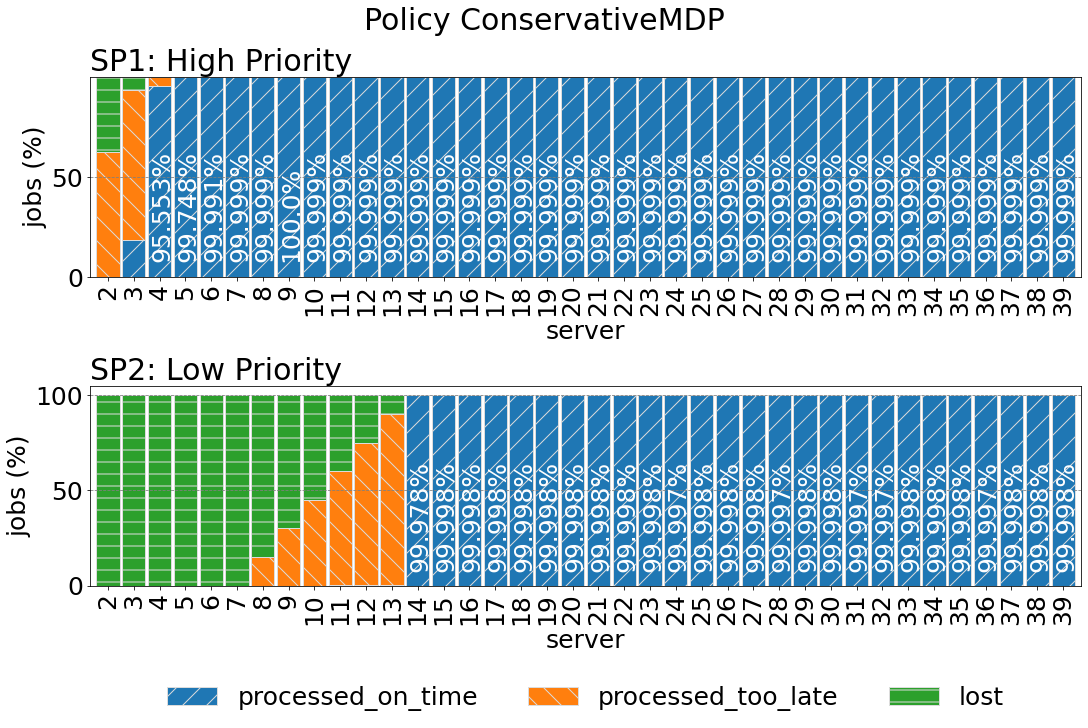

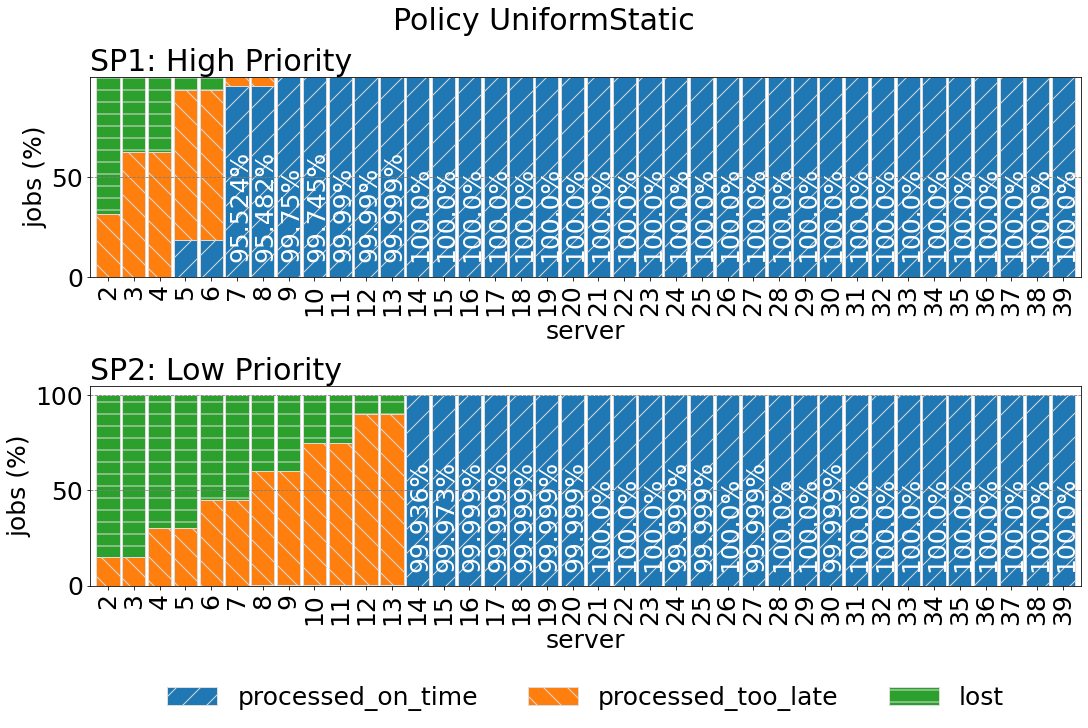

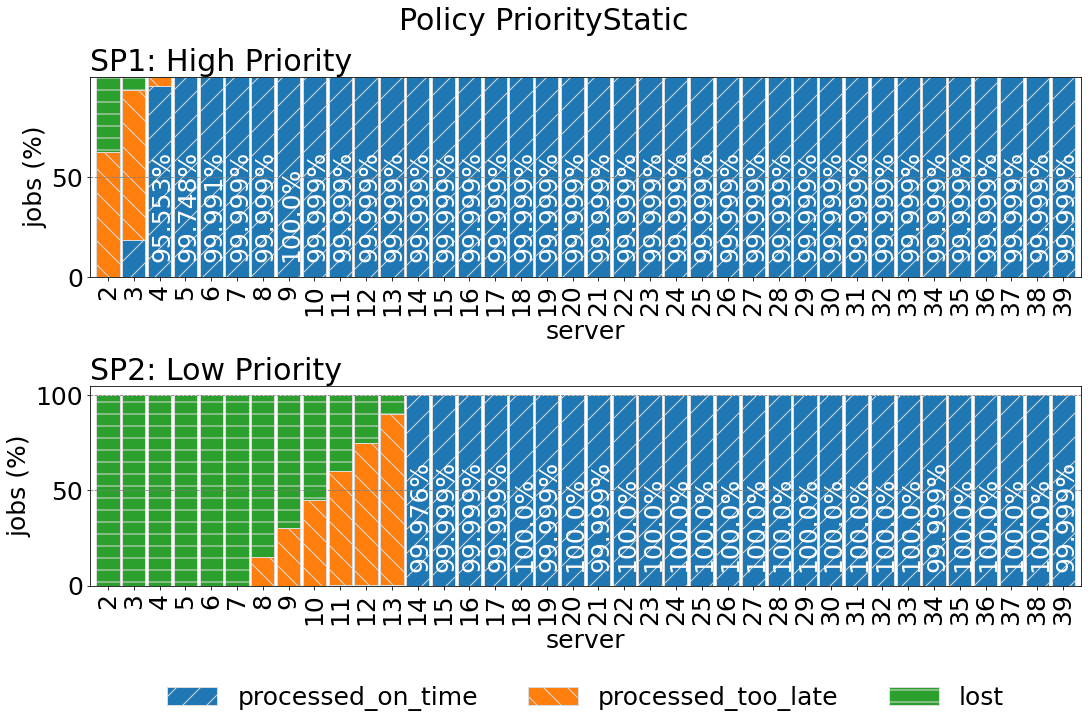

In [19]:
# this version should be used for two different services
patterns =('/','\\', '-')

new_df = deepcopy(dataframes)

#creating syntetic conservative mdp policy
a = deepcopy(dataframes[0])
a['name'] = 'ConservativeMDP'
a['slices'][0] = deepcopy(dataframes[3]['slices'][0])
a['slices'][1] = deepcopy(dataframes[1]['slices'][1])

new_df.insert(2, a)

policy_names = ["SequentialMDP", "SimplifiedMDP", "ConservativeMDP", "UniformStatic", "PriorityStatic"]
plt.rcParams.update({'font.size': 25})

for i in range(len(policy_names)):
    df0 = new_df[i]['slices'][0][['processed_on_time', 'processed_too_late', 'lost']]
    df1 = new_df[i]['slices'][1][['processed_on_time', 'processed_too_late', 'lost']]

    fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(15, 10))

    axs[0].set_title("SP1: High Priority", loc="left")
    axs[1].set_title("SP2: Low Priority", loc="left")
    axs[0].set_ylabel("jobs (%)")
    axs[1].set_ylabel("jobs (%)")

    axs[1].set_xlabel('servers (#)')

    fig.suptitle(f"Policy {policy_names[i]}")
    df0.plot(
        kind='bar',
        stacked=True,
        width=0.9,
        ax=axs[0],
        legend=False
    )

    axs[0].grid(axis='y', which='both', color='grey', linestyle='dashed')
    df1.plot(
        kind='bar',
        stacked=True,
        width=0.9,
        ax=axs[1],
        legend=False
    )

    axs[1].grid(axis='y', which='both', color='grey', linestyle='dashed')

    bars = axs[0].patches
    hatches = [p for p in patterns for i in range(len(df0))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        bar.set_edgecolor('gainsboro')
        
    bars = axs[1].patches
    hatches = [p for p in patterns for i in range(len(df0))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        bar.set_edgecolor('gainsboro')

    number_of_servers_max = len(df_processed_on_time_slice_0[policy_names[i]].tolist())
            
    for count, value in enumerate(axs[0].patches):
        if value.get_height() > 70 and count < number_of_servers_max:
            axs[0].text(value.get_x() + 0.1, 10,
                    str(truncate((value.get_height()), 3)) + '%', fontsize=25, color='white', rotation=90)
     
    for count, value in enumerate(axs[1].patches):
        if value.get_height() > 70 and count < number_of_servers_max:
            axs[1].text(value.get_x() + 0.1, 10,
                    str(truncate((value.get_height()), 3)) + '%', fontsize=25, color='white', rotation=90)



    
    axs[1].legend(bbox_to_anchor=(0.5, -0.45), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)
    plt.savefig(f"{OUTPUT_DIRECTORY_PATH}overview_policy-{policy_names[i]}_JUPYTER", bbox_inches='tight')

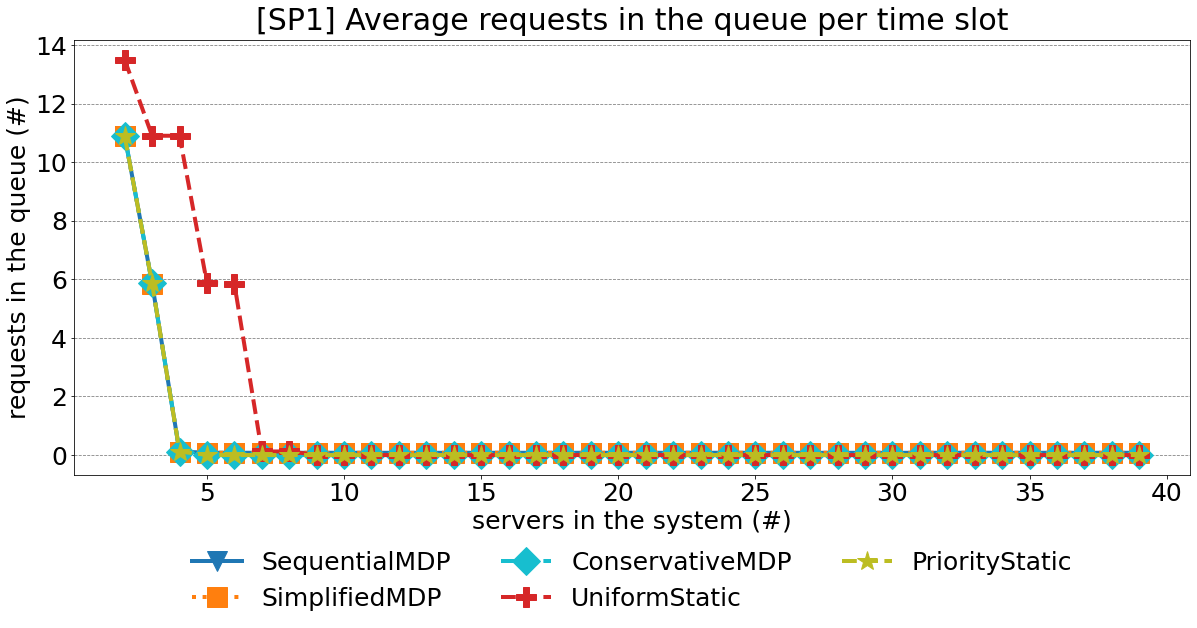

In [20]:
line_styles = ['-',':','-.','--', '--']
markers = ['v', 's', 'D', 'P', '*']

ax = (df_average_jobs_in_queue_slice_0).plot(
        kind='line',
        figsize=(20, 8),
        linewidth=4,
        style=line_styles,
        color=['tab:blue', 'tab:orange', 'tab:cyan', 'tab:red', 'tab:olive']
    )

ax.yaxis.grid(color='gray', linestyle='dashed')


ax.set_title(f"[SP1] Average requests in the queue per time slot", pad=10)
ax.set_ylabel('requests in the queue (#)')
ax.set_xlabel('servers in the system (#)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
    line.set_markersize(20)

    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}requestsinqueue_slice0_allpolicy_linestyle_JUPYTER", bbox_inches='tight')

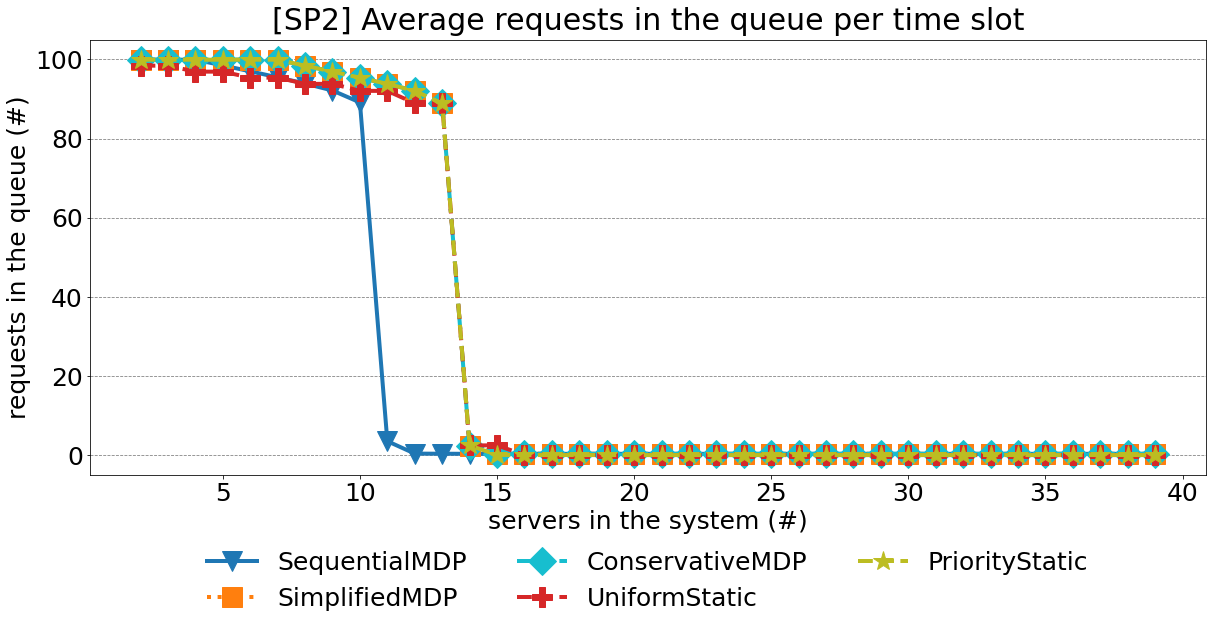

In [21]:
line_styles = ['-',':','-.','--', '--']
markers = ['v', 's', 'D', 'P', '*']

ax = (df_average_jobs_in_queue_slice_1).plot(
        kind='line',
        figsize=(20, 8),
        linewidth=4,
        style=line_styles,
        color=['tab:blue', 'tab:orange', 'tab:cyan', 'tab:red', 'tab:olive']
    )

ax.yaxis.grid(color='gray', linestyle='dashed')


ax.set_title(f"[SP2] Average requests in the queue per time slot", pad=10)
ax.set_ylabel('requests in the queue (#)')
ax.set_xlabel('servers in the system (#)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
    line.set_markersize(20)

    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}requestsinqueue_slice1_allpolicy_linestyle_JUPYTER", bbox_inches='tight')

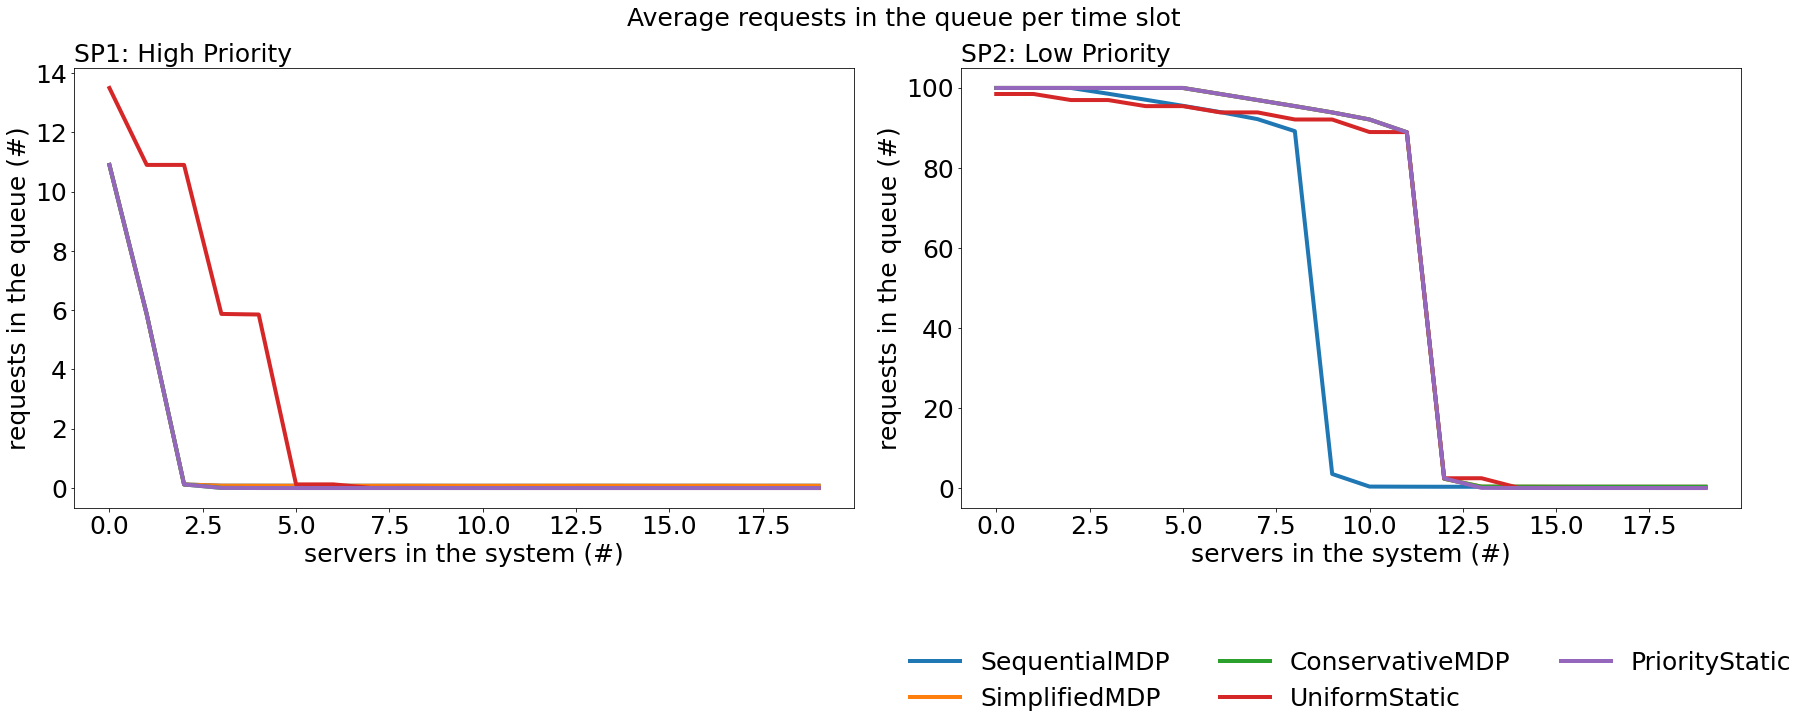

In [22]:
plt.rcParams.update({'font.size': 25})
line_styles = ['-',':','-.','--', '--']
markers = ['v', 's', 'D', 'P', '*']

fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(25, 10))
fig.suptitle('Average requests in the queue per time slot', fontsize=25)

ax1.set_title("SP1: High Priority", loc="left", fontsize=25)
ax2.set_title("SP2: Low Priority", loc="left", fontsize=25)

ax1.set_ylabel("requests in the queue (#)")
ax2.set_ylabel("requests in the queue (#)")

ax1.set_xlabel("servers in the system (#)")
ax2.set_xlabel("servers in the system (#)")

ax1.plot(range(0, 20), df_average_jobs_in_queue_slice_0['SequentialMDP'].to_list()[:20], label='SequentialMDP', linewidth=4)#, linestyle='-')
ax1.plot(range(0, 20), df_average_jobs_in_queue_slice_0['SimplifiedMDP'].to_list()[:20], label='SimplifiedMDP', linewidth=4)#, linestyle='-')
ax1.plot(range(0, 20), df_average_jobs_in_queue_slice_0['ConservativeMDP'].to_list()[:20], label='ConservativeMDP', linewidth=4)#, linestyle='-')
ax1.plot(range(0, 20), df_average_jobs_in_queue_slice_0['UniformStatic'].to_list()[:20], label='UniformStatic', linewidth=4)#, linestyle='-')
ax1.plot(range(0, 20), df_average_jobs_in_queue_slice_0['PriorityStatic'].to_list()[:20], label='PriorityStatic', linewidth=4)#, linestyle='-')


ax2.plot(range(0, 20), df_average_jobs_in_queue_slice_1['SequentialMDP'].to_list()[:20], label='SequentialMDP', linewidth=4)#, linestyle='-')
ax2.plot(range(0, 20), df_average_jobs_in_queue_slice_1['SimplifiedMDP'].to_list()[:20], label='SimplifiedMDP', linewidth=4)#, linestyle='-')
ax2.plot(range(0, 20), df_average_jobs_in_queue_slice_1['ConservativeMDP'].to_list()[:20], label='ConservativeMDP', linewidth=4)#, linestyle='-')
ax2.plot(range(0, 20), df_average_jobs_in_queue_slice_1['UniformStatic'].to_list()[:20], label='UniformStatic', linewidth=4)#, linestyle='-')
ax2.plot(range(0, 20), df_average_jobs_in_queue_slice_1['PriorityStatic'].to_list()[:20], label='PriorityStatic', linewidth=4)#, linestyle='-')


ax2.legend(bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)


plt.savefig(f"{OUTPUT_DIRECTORY_PATH}requestsinqueue_allslice_allpolicy_linestyle_JUPYTER", bbox_inches='tight')

In [23]:
df_average_jobs_in_queue_slice_0['SequentialMDP'].to_list()[:20]

[10.900202499999997,
 5.8559300000000025,
 0.12058249999999959,
 0.079067499999998,
 0.07887499999999828,
 0.07732999999999823,
 0.07828249999999813,
 0.07723749999999802,
 0.07861499999999816,
 0.07746999999999823,
 0.07649999999999828,
 0.07774999999999846,
 0.07641999999999831,
 0.07832499999999819,
 0.07758749999999859,
 0.0775799999999981,
 0.07799249999999815,
 0.07714999999999779,
 0.07743749999999815,
 0.07812249999999842]

# Scenario multi gausigma

In [24]:
BATCH_RESULT_PATH = [
    "C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/GAUSIGMA2/",
    "C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/GAUSIGMA5/",
    "C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/UNIF/"
]
OUTPUT_DIRECTORY_PATH = f"C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/plot/GAUSIGMA2/aggregated-GAUSIGMA2-new/"

DEADLINES = [1, 5]
TIMESLOTS = 10000

def get_results_path(start_path):
    to_ret = []

    for file in os.listdir(start_path):
        if os.path.isdir(os.path.join(start_path, file)):
            to_ret.append(os.path.join(start_path, file, 'results.data'))

    return to_ret

# results_path = get_results_path()

GAUX_PATH = [
    'C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/GAUSIGMA2/gausigma2_39/results.data',
    'C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/GAUSIGMA5/gausigma5_39/results.data',
    'C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/UNIF/unif_39/results.data'
]

In [25]:
# getting policies_aggregated_stats 
gau_x_dataframes = [] # 0 gausigma2 - 1 gausigma5 - 2 unif


# for g in GAUX_PATH:
#     policies_aggregated_stats = None
#     imported_data = utils.import_serialized_data(g)
#     if policies_aggregated_stats is None:
#         policies_aggregated_stats = [{'name': imported_data[i]['name'], 'stats_per_slice': []} for i in range(len(imported_data))]
    
# ------------
policies_aggregated_stats = None

for g in GAUX_PATH:
    imported_data = utils.import_serialized_data(g)
    if policies_aggregated_stats is None:
        policies_aggregated_stats = [{'sigma': g.split('/')[-2], 'name': imported_data[i]['name'], 'stats_per_slice': []} for i in range(len(imported_data))]

    for policy_index in range(len(imported_data)):
        policies_aggregated_stats[policy_index]['stats_per_slice'].append(
            {
             # the way we calculate the server_cap assumes the directory name like "something_NUMBEROFSERVERS"
             'sigma': g.split('/')[-2],
             'slices': []
             }
        )

        slices = filter_stats_per_slice(split_stats_per_slice(imported_data[policy_index]['environment_data']))
        
        policies_aggregated_stats[policy_index]['stats_per_slice'][-1]['slices'].append(
            {
                'active_servers': slices[0]['active_servers']
             }
        )

        policies_aggregated_stats[policy_index]['stats_per_slice'][-1]['slices'].append(
            {
                'active_servers': slices[1]['active_servers']
            }
        )
        
dataframes = []

for policy in policies_aggregated_stats:
    sigma = []
    active_servers = [[], []]
    

    for s in policy['stats_per_slice']:
        sigma.append(s['sigma'])

        active_servers[0].append(s['slices'][0]['active_servers'])
        active_servers[1].append(s['slices'][1]['active_servers'])
        
        

    dataframes.append(
        {
            'name': policy['name'],
            'slices': [
                pd.DataFrame({  # slice high priority
                    'sigma': sigma,
                    'active_servers': active_servers[0],
                }),
                pd.DataFrame({  # slice low priority
                    'sigma': sigma,
                    'active_servers': active_servers[1],
                })
            ]
        }
    )

#     dataframes[-1]['slices'][0]['server'] = dataframes[-1]['slices'][0].astype(int)
#     dataframes[-1]['slices'][1]['server'] = dataframes[-1]['slices'][1].astype(int)
#     dataframes[-1]['slices'][0] = dataframes[-1]['slices'][0].sort_values(by=["server"]).set_index("server")
#     dataframes[-1]['slices'][1] = dataframes[-1]['slices'][1].sort_values(by=["server"]).set_index("server")

In [26]:
slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_active_servers_slice_0 = \
    pd.DataFrame({
        'sigma': slice_0[0]['sigma'],
        'SequentialMDP': (slice_0[0]['active_servers']),
        'SimplifiedMDP': (slice_0[1]['active_servers']),
        'ConservativeMDP': (slice_0[3]['active_servers']),
        'UniformStatic': (slice_0[2]['active_servers']),
        'PriorityStatic': (slice_0[3]['active_servers']),
                 })

for sigma_index in range(len(df_active_servers_slice_0['sigma'])):
    if 'unif' in df_active_servers_slice_0['sigma'][sigma_index]:
        df_active_servers_slice_0['sigma'][sigma_index] = 'uniform'
    elif '2' in df_active_servers_slice_0['sigma'][sigma_index]:
        df_active_servers_slice_0['sigma'][sigma_index] = 'σ=2'
    elif '5' in df_active_servers_slice_0['sigma'][sigma_index]:
        df_active_servers_slice_0['sigma'][sigma_index] = 'σ=5'
        
    
df_active_servers_slice_1 = \
    pd.DataFrame({
        'sigma': slice_1[0]['sigma'],
        'SequentialMDP': (slice_1[0]['active_servers']).to_list(),
        'SimplifiedMDP': (slice_1[1]['active_servers']).to_list(),
        'ConservativeMDP': (slice_1[1]['active_servers']).to_list(),
        'UniformStatic': (slice_1[2]['active_servers']).to_list(),
        'PriorityStatic': (slice_1[3]['active_servers']).to_list(),
    })

for sigma_index in range(len(df_active_servers_slice_1['sigma'])):
    if 'unif' in df_active_servers_slice_1['sigma'][sigma_index]:
        df_active_servers_slice_1['sigma'][sigma_index] = 'uniform'
    elif '2' in df_active_servers_slice_0['sigma'][sigma_index]:
        df_active_servers_slice_1['sigma'][sigma_index] = 'σ=2'
    elif '5' in df_active_servers_slice_0['sigma'][sigma_index]:
        df_active_servers_slice_1['sigma'][sigma_index] = 'σ=5'

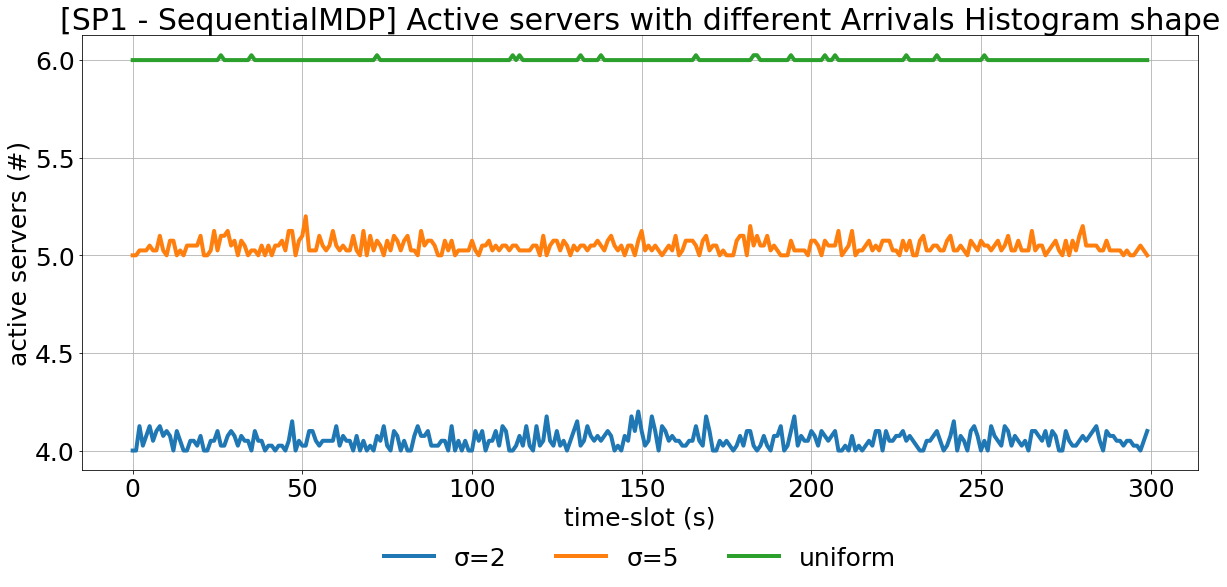

In [27]:
line_styles = ['-',':','-.','--', '--']
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(20, 8))
ax.grid(True)
ax.set_title('[SP1 - SequentialMDP] Active servers with different Arrivals Histogram shape')
ax.set_xlabel('time-slot (s)')
ax.set_ylabel('active servers (#)')

df_active_servers_slice_0['SequentialMDP']
plt.plot(range(0, 300), df_active_servers_slice_0['SequentialMDP'][0][:300], label=df_active_servers_slice_0['sigma'][0], linewidth=4)
plt.plot(range(0, 300), df_active_servers_slice_0['SequentialMDP'][1][:300], label=df_active_servers_slice_0['sigma'][1], linewidth=4)
plt.plot(range(0, 300), df_active_servers_slice_0['SequentialMDP'][2][:300], label=df_active_servers_slice_0['sigma'][2], linewidth=4)

ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}activeserver_slice0_sequentialmdp_JUPYTER", bbox_inches='tight')

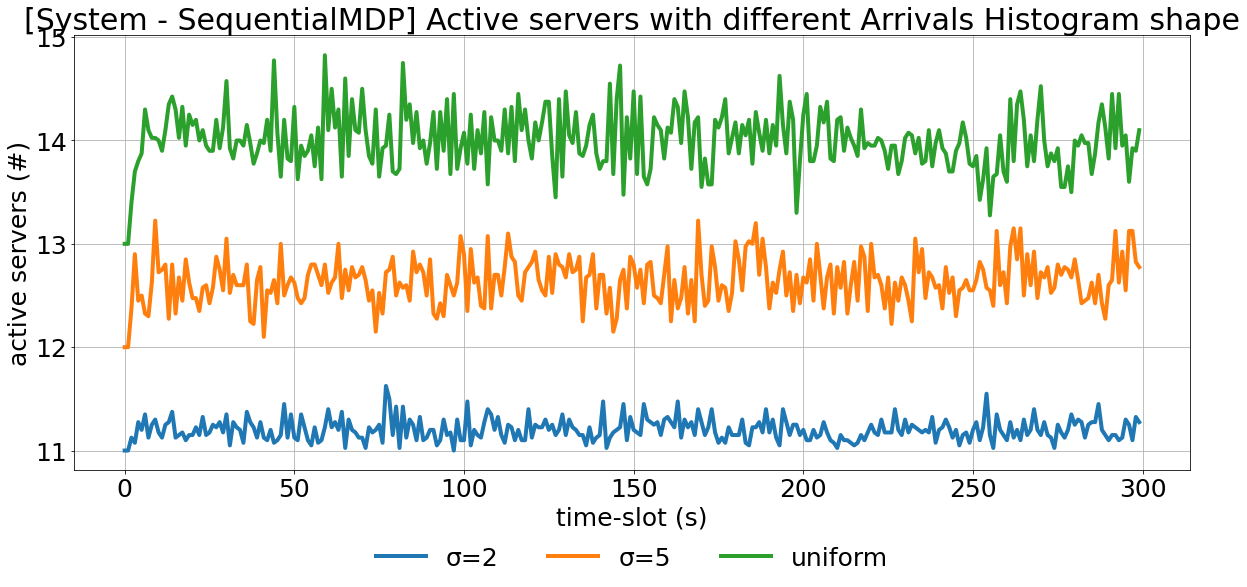

In [28]:
from operator import add
# >>> list( map(add, list1, list2) )

line_styles = ['-',':','-.','--', '--']
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(20, 8))
ax.grid(True)
ax.set_title('[System - SequentialMDP] Active servers with different Arrivals Histogram shape')
ax.set_xlabel('time-slot (s)')
ax.set_ylabel('active servers (#)')

df_active_servers_slice_0['SequentialMDP']

list1 = df_active_servers_slice_0['SequentialMDP'][0][:300]
list2 = df_active_servers_slice_1['SequentialMDP'][0][:300]
plt.plot(range(0, 300), list( map(add, list1, list2) ), label=df_active_servers_slice_0['sigma'][0], linewidth=4)

list1 = df_active_servers_slice_0['SequentialMDP'][1][:300]
list2 = df_active_servers_slice_1['SequentialMDP'][1][:300]
plt.plot(range(0, 300), list( map(add, list1, list2) ), label=df_active_servers_slice_0['sigma'][1], linewidth=4)

list1 = df_active_servers_slice_0['SequentialMDP'][2][:300]
list2 = df_active_servers_slice_1['SequentialMDP'][2][:300]
plt.plot(range(0, 300), list( map(add, list1, list2) ), label=df_active_servers_slice_0['sigma'][2], linewidth=4)

ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}activeserver_allslice_sequentialmdp_JUPYTER", bbox_inches='tight')

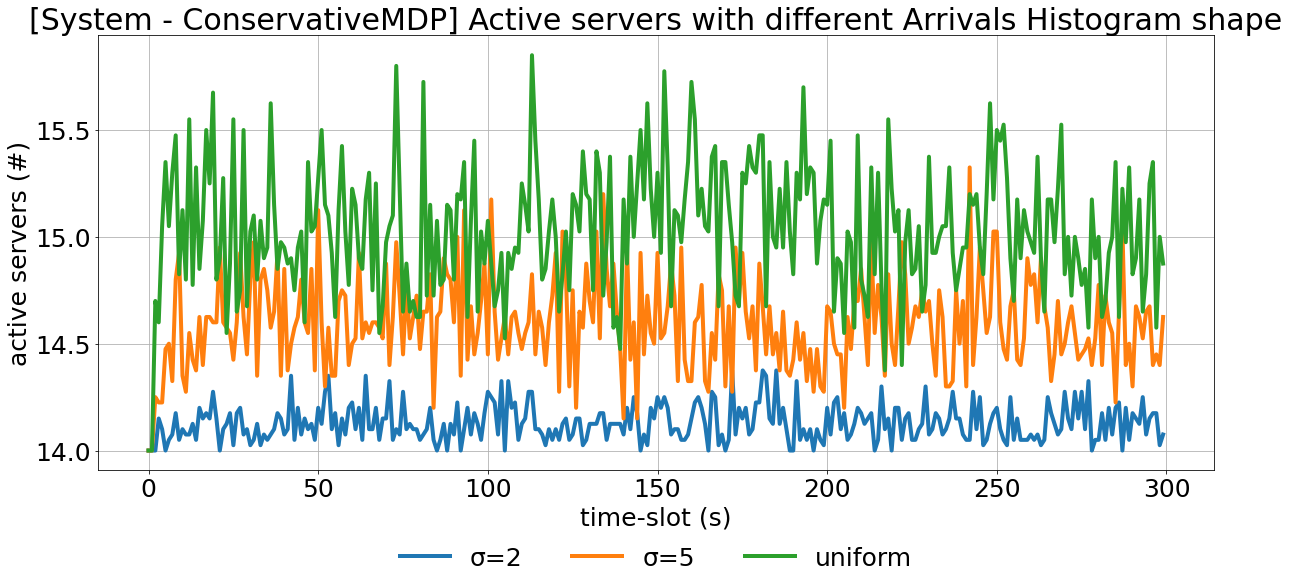

In [29]:
from operator import add

line_styles = ['-',':','-.','--', '--']
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(20, 8))
ax.grid(True)
ax.set_title('[System - ConservativeMDP] Active servers with different Arrivals Histogram shape')
ax.set_xlabel('time-slot (s)')
ax.set_ylabel('active servers (#)')

df_active_servers_slice_0['ConservativeMDP']

list1 = df_active_servers_slice_0['ConservativeMDP'][0][:300]
list2 = df_active_servers_slice_1['ConservativeMDP'][0][:300]
plt.plot(range(0, 300), list( map(add, list1, list2) ), label=df_active_servers_slice_0['sigma'][0], linewidth=4)

list1 = df_active_servers_slice_0['ConservativeMDP'][1][:300]
list2 = df_active_servers_slice_1['ConservativeMDP'][1][:300]
plt.plot(range(0, 300), list( map(add, list1, list2) ), label=df_active_servers_slice_0['sigma'][1], linewidth=4)

list1 = df_active_servers_slice_0['ConservativeMDP'][2][:300]
list2 = df_active_servers_slice_1['ConservativeMDP'][2][:300]
plt.plot(range(0, 300), list( map(add, list1, list2) ), label=df_active_servers_slice_0['sigma'][2], linewidth=4)

ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}activeserver_allslice_conservativemdp_JUPYTER", bbox_inches='tight')

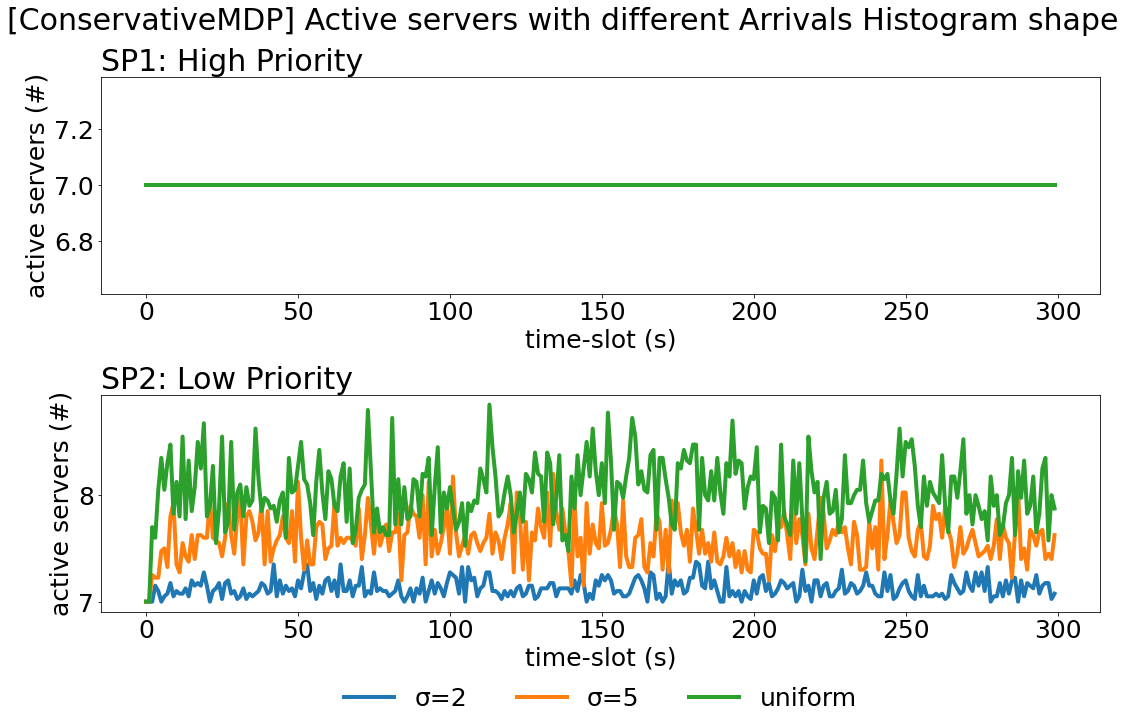

In [30]:
plt.rcParams.update({'font.size': 25})

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(15, 10))
fig.suptitle('[ConservativeMDP] Active servers with different Arrivals Histogram shape')

axs[0].set_title("SP1: High Priority", loc="left")
axs[1].set_title("SP2: Low Priority", loc="left")

axs[0].set_ylabel("active servers (#)")
axs[1].set_ylabel("active servers (#)")

axs[0].set_xlabel("time-slot (s)")
axs[1].set_xlabel("time-slot (s)")

axs[0].plot(range(0, 300), df_active_servers_slice_0['ConservativeMDP'][0][:300], label=df_active_servers_slice_0['sigma'][0], linewidth=4)#, linestyle='-')
axs[0].plot(range(0, 300), df_active_servers_slice_0['ConservativeMDP'][1][:300], label=df_active_servers_slice_0['sigma'][1], linewidth=4)#, linestyle='--')
axs[0].plot(range(0, 300), df_active_servers_slice_0['ConservativeMDP'][2][:300], label=df_active_servers_slice_0['sigma'][2], linewidth=4)#, linestyle='-.')

axs[1].plot(range(0, 300), df_active_servers_slice_1['ConservativeMDP'][0][:300], label=df_active_servers_slice_0['sigma'][0], linewidth=4)#, linestyle='-')
axs[1].plot(range(0, 300), df_active_servers_slice_1['ConservativeMDP'][1][:300], label=df_active_servers_slice_0['sigma'][1], linewidth=4)#, linestyle='--')
axs[1].plot(range(0, 300), df_active_servers_slice_1['ConservativeMDP'][2][:300], label=df_active_servers_slice_0['sigma'][2], linewidth=4)#, linestyle='-.')


axs[1].legend(bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)


plt.savefig(f"{OUTPUT_DIRECTORY_PATH}activeserver_allslice_conservativemdp_JUPYTER", bbox_inches='tight')

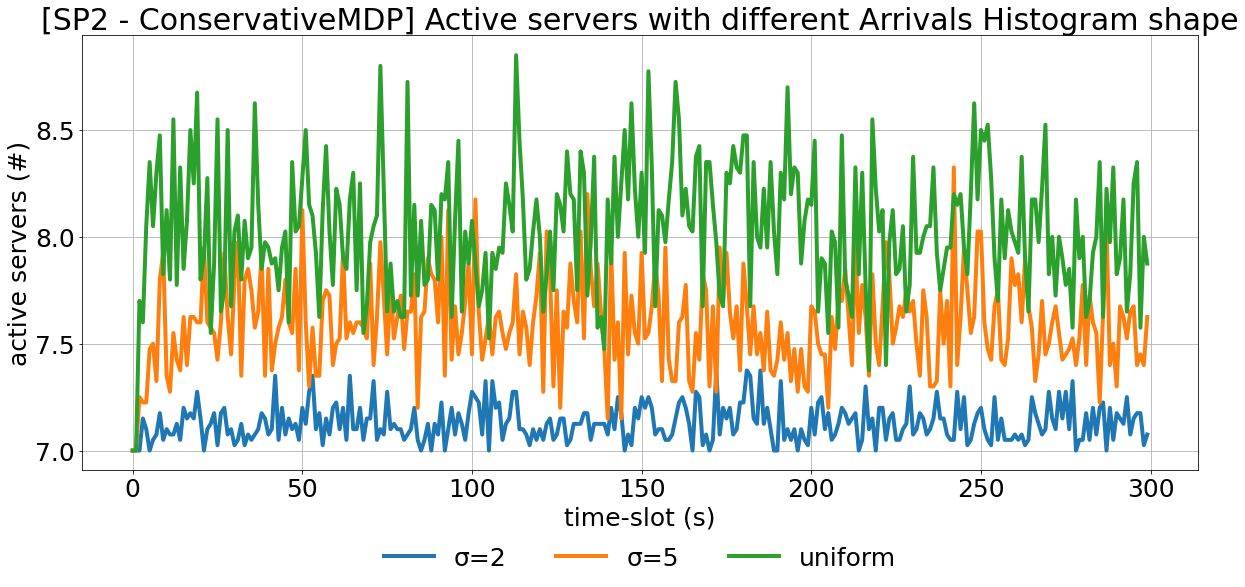

In [31]:
line_styles = ['-',':','-.','--', '--']
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(20, 8))
ax.grid(True)
ax.set_title('[SP2 - ConservativeMDP] Active servers with different Arrivals Histogram shape')
ax.set_xlabel('time-slot (s)')
ax.set_ylabel('active servers (#)')

df_active_servers_slice_0['SequentialMDP']
plt.plot(range(0, 300), df_active_servers_slice_1['ConservativeMDP'][0][:300], label=df_active_servers_slice_0['sigma'][0], linewidth=4)
plt.plot(range(0, 300), df_active_servers_slice_1['ConservativeMDP'][1][:300], label=df_active_servers_slice_0['sigma'][1], linewidth=4)
plt.plot(range(0, 300), df_active_servers_slice_1['ConservativeMDP'][2][:300], label=df_active_servers_slice_0['sigma'][2], linewidth=4)

ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}activeserver_slice1_conservativemdp_JUPYTER", bbox_inches='tight')